# Time-warped PCA analysis
*Nhat Le, November 2017*

In [5]:
#import twpca
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtw
import sys
import tensorflow as tf
import scipy.stats
import os

%matplotlib inline

In [6]:
# Insert path to twpca directory
sys.path.insert(0, 'C://Users/Le/Documents/MIT/Fee/twpca/')


In [7]:
from twpca import *

## Getting a better sense of twpca warp

In [8]:
def gauss_fun(t, t0, sigma):
    '''Gaussian function centered at t0'''
    return np.exp(-(t - t0)**2 / sigma**2)

gauss_fun_vec = np.vectorize(gauss_fun)

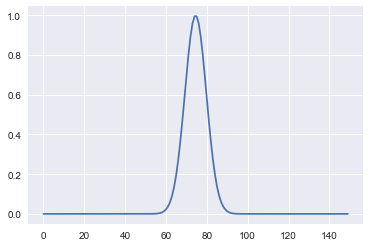

In [9]:
t = np.linspace(-10, 10, 150)
sig = gauss_fun(t, 0, 1)
plt.plot(sig)

warptest = np.arange(len(t))
warptest = warptest[:, np.newaxis] + 50

modelN = TWPCA(sig, 1, warps=warptest.T)

In [10]:
modelN.params['warp']

array([[  50.        ,   51.        ,   52.        ,   53.        ,
          54.        ,   55.        ,   56.        ,   57.        ,
          58.        ,   59.        ,   60.        ,   61.        ,
          62.        ,   63.        ,   64.        ,   65.        ,
          66.        ,   67.        ,   68.        ,   69.        ,
          70.        ,   71.        ,   72.        ,   73.        ,
          74.        ,   75.        ,   76.        ,   77.        ,
          78.        ,   79.        ,   80.        ,   81.        ,
          82.        ,   83.        ,   84.        ,   85.        ,
          86.        ,   87.        ,   88.        ,   89.        ,
          90.        ,   91.        ,   92.        ,   93.        ,
          94.        ,   95.        ,   96.        ,   97.        ,
          98.        ,   99.        ,  100.        ,  101.        ,
         102.        ,  103.        ,  104.        ,  105.        ,
         106.        ,  107.        ,  108.     

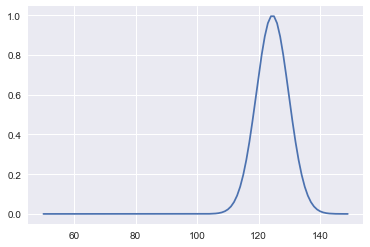

In [11]:
#modelN.fit()
res = modelN.transform()
plt.plot(np.squeeze(res))

## Synthetic data

### Shifted Gaussians

In [12]:
def run_twpca(data, ncomp, init_mode, warp_mode, num_iter=1000, rate=1e-3, origin=None):
    '''Wrapper for running twPCA.
    Returns: model: the model twPCA returns
    recons: the aligned data
    warp: the warp factor'''
    model1 = TWPCA(data, n_components=ncomp, warpinit=init_mode, warptype=warp_mode, origin_idx=origin)
    model1.fit(niter=num_iter, lr=rate)
    recons = model1.transform()
    warp = model1.params['warp']
    return model1, recons, warp

In [13]:
t = np.linspace(-10, 10, 150)
np.random.seed(1235)
nsamples = 100
jitters = np.random.randn(nsamples)
sort_jitters = np.sort(jitters)

array = [gauss_fun(t, t0, 1) for t0 in sort_jitters]
all_obs = np.vstack(array)

# Add noise
noise = np.random.normal(scale=0.05, size=all_obs.shape)
all_obs += noise


In [14]:
model_gauss, recons_gauss, warp_gauss = run_twpca(all_obs, 1, init_mode='shift', warp_mode='shift')

100%|█████████████████████████████████████| 1000/1000 [00:05<00:00, 167.49it/s]


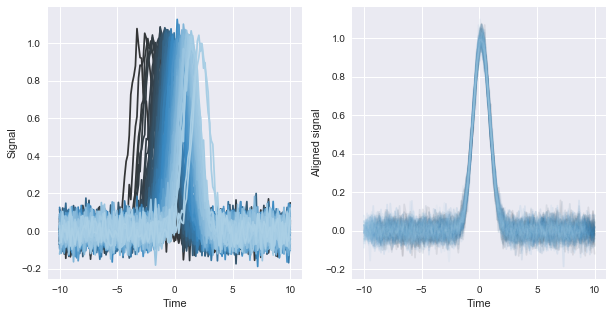

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
palette_fig1 = sns.color_palette('Blues_d', nsamples)

for i in range(nsamples):
    ax[0].plot(t, all_obs[i,:], color=palette_fig1[i]);
    ax[1].plot(t, recons_gauss[i,:,0], color=palette_fig1[i], alpha=0.1);
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Signal')
    
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Aligned signal')
plt.savefig('twpca_gaussians_100_171101_seed1234_initwarp_shift_warptype_shift2.pdf')

### Scaled gaussian

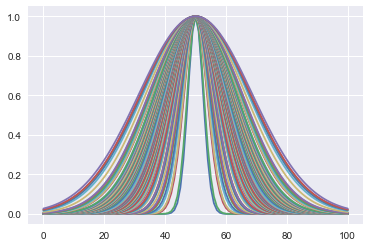

In [16]:
t = np.linspace(-10, 10, 101)
np.random.seed(1231)
nsamples = 100
jitters = np.random.randn(nsamples)
scale_jitters = np.abs(np.random.normal(loc=3, size=nsamples))
scale_jitters = np.sort(scale_jitters)

sort_jitters = np.sort(jitters)

array = [gauss_fun(t, 0, sigma) for sigma in scale_jitters]
all_obs = np.vstack(array)

# Add noise
#noise = np.random.normal(scale=0.05, size=all_obs.shape)
#all_obs += noise
plt.plot(all_obs[:,].T);

In [17]:
model_gauss, recons_gauss, warp_gauss = run_twpca(all_obs, 1, init_mode='identity', warp_mode='scale',
                                                 num_iter=5000, rate=1e-2, origin=50)

100%|█████████████████████████████████████| 5000/5000 [00:24<00:00, 202.63it/s]


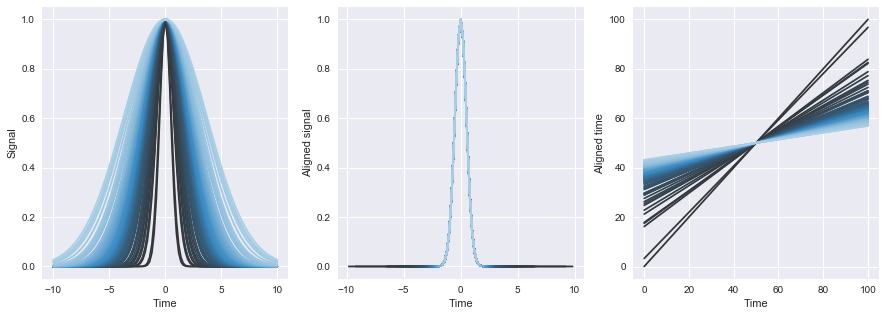

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
palette_fig1 = sns.color_palette('Blues_d', nsamples)

for i in range(nsamples):
    ax[0].plot(t, all_obs[i,:], color=palette_fig1[i]);
    ax[1].plot(t, recons_gauss[i,:,0], color=palette_fig1[i]);
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Signal')
    
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Aligned signal')
    
    ax[2].plot(warp_gauss[i,:], color=palette_fig1[i]);
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Aligned time')
plt.savefig('twpca_gaussians_noise_100_171101_seed1231_initwarp_identity_warptype_affine.pdf')

### Scaled and shifted Gaussians

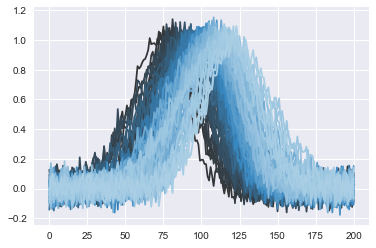

In [19]:
t = np.linspace(-10, 10, 201)
np.random.seed(1231)
nsamples = 100
jitters = np.random.randn(nsamples)
scale_jitters = np.abs(np.random.normal(size=nsamples)) + 2

sort_jitters = np.sort(jitters)

array = [gauss_fun(t, t0, sigma) for t0, sigma in zip(sort_jitters, scale_jitters)]
all_obs = np.vstack(array)

# Add noise
noise = np.random.normal(scale=0.05, size=all_obs.shape)
all_obs += noise

with sns.color_palette('Blues_d', 100):
    plt.plot(all_obs[:,].T);

In [20]:
model_gauss, recons_gauss, warp_gauss = run_twpca(all_obs, 1, init_mode='identity', warp_mode='affine',
                                                 num_iter=5000, rate=1e-2)

100%|█████████████████████████████████████| 5000/5000 [00:41<00:00, 120.27it/s]


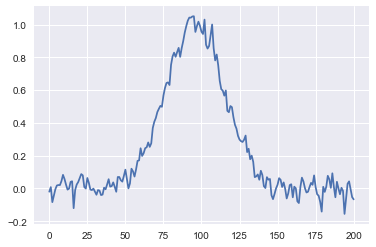

In [21]:
plt.plot(recons_gauss[9,:,0].T);

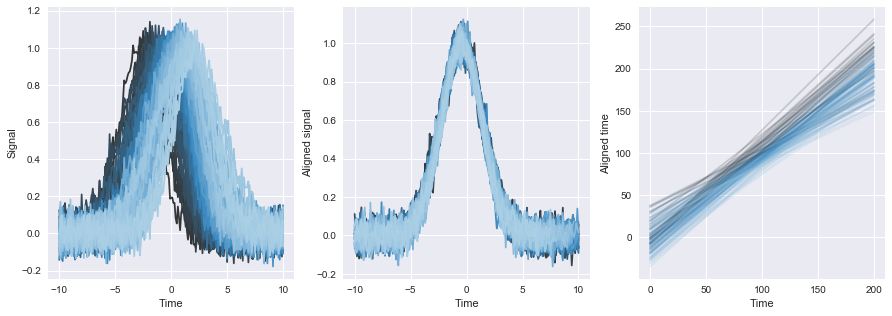

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
palette_fig1 = sns.color_palette('Blues_d', nsamples)

for i in range(nsamples):
    ax[0].plot(t, all_obs[i,:], color=palette_fig1[i]);
    ax[1].plot(t, recons_gauss[i,:,0], color=palette_fig1[i]);
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Signal')
    
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Aligned signal')
    
    ax[2].plot(warp_gauss[i,:], color=palette_fig1[i], alpha=0.2);
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Aligned time')
plt.savefig('twpca_gaussians_mix_100_171101_seed1231_initwarp_shift_warptype_affine.pdf')

## Dynamic time-warping of neural data

In [23]:
# Read in the neural data
short_psth = np.genfromtxt('./psth_short_all_neurons_nans_171102.csv', delimiter=',')
long_psth = np.genfromtxt('./psth_long_all_neurons_nans_171102.csv', delimiter=',')

t_points_short = 7
t_points_long = 9
n_neurons = 105
dt_bin = 40 #ms

In [24]:
# Reshape the short and long raw data into tensors
reshaped_short_psth = np.reshape(short_psth, (n_neurons, t_points_short, -1))
reshaped_long_psth = np.reshape(long_psth, (n_neurons, t_points_long, -1))
duration_short = reshaped_short_psth.shape[2]
duration_long = reshaped_long_psth.shape[2]

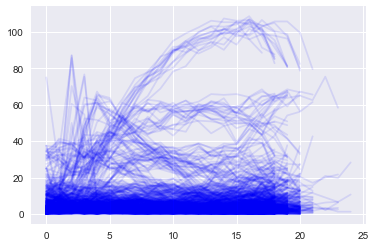

In [25]:
plt.plot(short_psth.T, 'blue', alpha=0.1);

In [26]:
# Combine short and long trials into one tensor
reshaped_short_pad = np.lib.pad(reshaped_short_psth, ((0,0), (0,0), (0,46-25)), 
                                'constant', constant_values=(np.nan, np.nan))
reshaped_all_pad = np.concatenate((reshaped_short_pad, reshaped_long_psth), axis=1)

# Swap axes to feed in twpca
swapped_all = np.swapaxes(reshaped_all_pad, 0, 2)
swapped_all = np.swapaxes(swapped_all, 0, 1)

In [27]:
# Define palette used in plotting
palette_blue = sns.palettes.color_palette('Blues', t_points_short)
palette_red = sns.palettes.color_palette('Reds', t_points_long)

OSError: File exists!

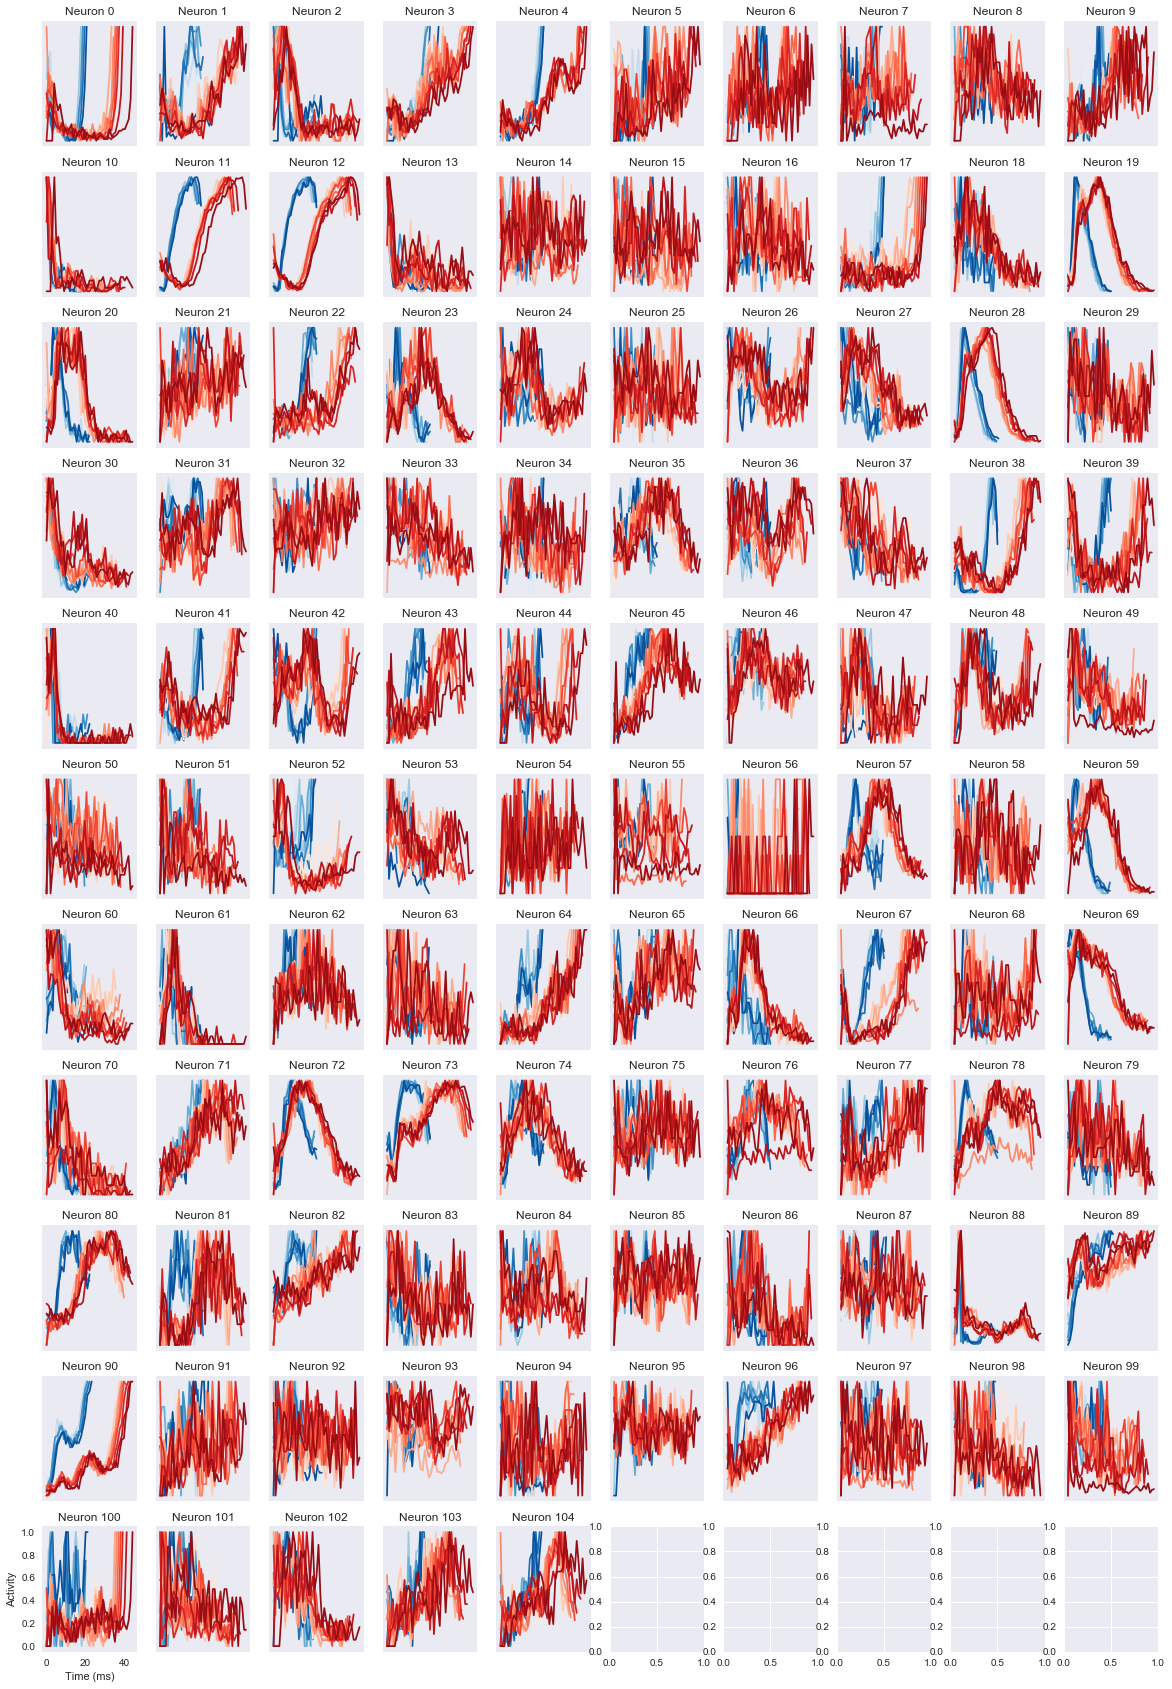

In [29]:
ncols = 10
nrows = 11
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 30))

for i in range(nrows):
    for j in range(ncols):
        neuron_id = ncols * i + j
        if neuron_id >= n_neurons:
            break
        neuron1 = swapped_all[:,:,neuron_id]
        # Normalize max PSTH to 1
        neuron1 = neuron1 / np.nanmax(neuron1, axis=1)[:,np.newaxis]

        for k in range(t_points_short):
            ax[i][j].plot(neuron1[k, :], color=palette_blue[k]);

        for k in range(t_points_long):
            ax[i][j].plot(neuron1[t_points_short + k, :], color=palette_red[k]);    

        ax[i][j].grid(False)
        ax[i][j].set_title('Neuron ' + str(neuron_id))
            
        if i != nrows - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Activity')
            #ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
    
filename = 'all_activities_jing105.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    raise IOError('File exists!')

Starting twpca...


100%|█████████████████████████████████████| 5000/5000 [00:06<00:00, 806.44it/s]


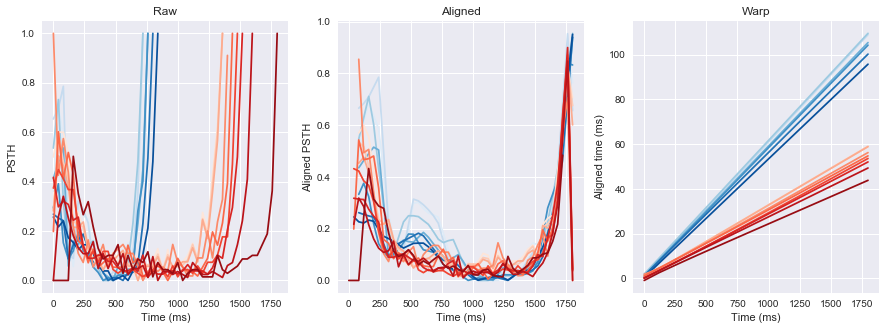

In [33]:
neuron_id = 17
neuron1 = swapped_all[:,:,0]
# Normalize max PSTH to 1
neuron1 = neuron1 / np.nanmax(neuron1, axis=1)[:,np.newaxis]

print('Starting twpca...')

mode_init = 'linear'
mode_warp = 'tau'
modelN, reconsN, warpN = run_twpca(neuron1, 1, init_mode=mode_init, warp_mode=mode_warp,
                                  num_iter=5000, rate=1e-2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
timepts = np.arange(duration_long) * dt_bin

for i in range(t_points_short):
    ax[0].plot(timepts, neuron1[i, :], color=palette_blue[i]);
    ax[1].plot(timepts, reconsN[i, :, 0], color=palette_blue[i]);
    ax[2].plot(timepts, warpN[i, :], color=palette_blue[i]);
    
for i in range(t_points_long):
    ax[0].plot(timepts, neuron1[t_points_short + i, :], color=palette_red[i]);    
    ax[1].plot(timepts, reconsN[t_points_short + i, :, 0], color=palette_red[i]);  
    ax[2].plot(timepts, warpN[t_points_short + i, :], color=palette_red[i]);    


ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('PSTH')
ax[0].set_title('Raw')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Aligned')
ax[1].set_ylabel('Aligned PSTH')
ax[2].set_title('Warp')
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Aligned time (ms)')

filename = 'neuron' + str(neuron_id) + '_twpca_init_' + mode_init + \
    '_warp_' + mode_warp + '_171102_rate10e-2.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    raise IOError('File exists!')

## Run on multiple neurons

In [ ]:
warp_lst = []
recons_lst = []
for neuron_id in range(150):
    neuron1 = swapped_all[:,:,neuron_id]
    # Normalize max PSTH to 1
    neuron1 = neuron1 / np.nanmax(neuron1, axis=1)[:,np.newaxis]

    print('Starting twpca, neuron' , str(neuron_id), '...')

    mode_init = 'linear'
    mode_warp = 'tau'
    modelN, reconsN, warpN = run_twpca(neuron1, 1, init_mode=mode_init, warp_mode=mode_warp,
                                      num_iter=5000, rate=1e-2)
    warp_lst.append(warpN)
    recons_lst.append(reconsN)


In [ ]:
timepts_r = timepts[:, np.newaxis] 
coefs = np.zeros((2, warpN.shape[0]))
for i in range(warpN.shape[0]):
    line = np.ones((warpN.shape[1], 2))
    line[:, 0] = warpN[i,:]* dt_bin
    coefs[:, i] = np.dot(np.linalg.inv(np.dot(line.T, line)), np.dot(line.T, timepts_r)).ravel()
    
T_arr = np.array([740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
T_arr_theory = np.array([0, 740, 760, 780, 800, 820, 840, 860, 1300, 1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620])
plt.plot(T_arr, coefs[0, :], '.')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(T_arr, coefs[0,:])
plt.plot(T_arr_theory, T_arr_theory * slope + intercept, 'g--', alpha=0.4)    

plt.xlim(0, 1750)
#plt.ylim(-0.2, 1)
plt.xlabel('Length (ms)')
plt.ylabel('Stretch factor')
filename = 'neuron' + str(neuron_id) + '_stretch_init_' + mode_init + \
    '_warp_' + mode_warp + '_171102_rate10e-2.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    raise IOError('File exists!')

In [ ]:
swapped = np.swapaxes(reshaped_short_psth, 0, 2)
swapped = np.swapaxes(swapped, 0, 1)
swapped = swapped[:,:19,12]
swapped = swapped[:,:,np.newaxis]

model = twpca.TWPCA(n_components=1)
model.fit(swapped)
aligned = model.transform()

In [ ]:
swapped_long = np.swapaxes(reshaped_long_psth, 0, 2)
swapped_long = np.swapaxes(swapped_long, 0, 1)
model_long = twpca.TWPCA(n_components=1)
model_long.fit(swapped_long)
aligned_long = model_long.transform()

In [ ]:
model_all = twpca.TWPCA(n_components=1)
model_all.fit(swapped_all)
aligned_all = model_all.transform()

In [ ]:
V = model.params['time']
U = model.params['neuron']


In [ ]:
model.transform??

In [ ]:
# Plot warp factors and alignment
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
a = model.params['warp']
neuron_id = 0
before_align = swapped[:,:,neuron_id]
after_align = aligned[:,:,neuron_id]
timestamps = np.arange(a.shape[1]) * 40



for i in range(7):
    ax[0].plot(timestamps, a[i,:] * 40, color=palette_blue[i]) 
    ax[1].plot(timestamps, before_align[i,:], color=palette_blue[i]); 
    ax[2].plot(timestamps, after_align[i,:], color=palette_blue[i]);
ax[0].set_xlabel('Time (ms)')
ax[1].set_xlabel('Time (ms)')
ax[2].set_xlabel('Time (ms)')

ax[0].set_ylabel('Adjusted time (ms)')
ax[1].set_ylabel('PSTH')
ax[2].set_ylabel('Aligned PSTH')
plt.savefig('short_twpca_alignment.pdf')

    
    
    

In [ ]:
# Plot warp factors and alignment
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
a = model_long.params['warp']
neuron_id = 12
before_align = swapped_long[:,:,neuron_id]
after_align = aligned_long[:,:,neuron_id]
timestamps = np.arange(a.shape[1]) * 40

for i in range(9):
    ax[0].plot(timestamps, a[i,:] * 40, color=palette_red[i]) 
    ax[1].plot(timestamps, before_align[i,:], color=palette_red[i]);    
    ax[2].plot(timestamps, after_align[i,:], color=palette_red[i]);
    
ax[0].set_xlabel('Time (ms)')
ax[1].set_xlabel('Time (ms)')
ax[2].set_xlabel('Time (ms)')

ax[0].set_ylabel('Adjusted time (ms)')
ax[1].set_ylabel('PSTH')
ax[2].set_ylabel('Aligned PSTH')

plt.savefig('long_twpca_alignment.pdf')


In [ ]:
# Plot warp factors and alignment
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
a = model_all.params['warp']
neuron_id = 3

for i in range(16):
    ax[0].plot(a[i,:], color=palette_blue[i]) 

before_align = swapped_all[:,:,neuron_id]
for i in range(16):
    ax[1].plot(before_align[i,:], color=palette_blue[i]);    
    
after_align = aligned_all[:,:,neuron_id]
for i in range(16):
    ax[2].plot(after_align[i,:], color=palette_blue[i]);

In [ ]:
swapped_single.shape

In [ ]:
model_single

Effort to align short and long trials... 

In [ ]:
warp_lst = []
for i in range(150):
    # Extract only one trial in each short/long condition
    swapped_single = swapped_all[:t_points_short,:,i]

    print('Doing neuron #', i, '...')

    model_single = twpca.TWPCA(n_components=1)
    model_single.fit(swapped_single)
    warp_lst.append(model_single.params['warp'])
    #aligned_single = model_single.transform()

In [ ]:
warp_lst_long = []
for i in range(150):
    # Extract only one trial in each short/long condition
    swapped_single = swapped_all[t_points_short:,:,i]

    print('Doing neuron #', i, '...')

    model_single = twpca.TWPCA(n_components=1)
    model_single.fit(swapped_single)
    warp_lst_long.append(model_single.params['warp'])
    #aligned_single = model_single.transform()

In [ ]:
for warp in warp_lst:
    plt.plot(warp[0,:], 'b', alpha=0.05)
    plt.plot(warp[6,:], 'r', alpha=0.05)

In [ ]:
mean_warp = np.zeros_like(warp_lst[0])
for warp in warp_lst:
    mean_warp += warp / len(warp_lst)

In [ ]:
with sns.color_palette('Blues', 7):
    plt.plot(mean_warp.T);

In [ ]:
with sns.color_palette('Blues', 7):
    plt.plot(np.diff(mean_warp).T)

In [ ]:
def my_jittered_neuron(t=None, feature=None, n_trial=61, jitter=1.0, gain=0.0, noise=0.05, seed=1234):
    """Generates a synthetic dataset of a single neuron with a jittered firing pattern.
    Parameters
    ----------
    t : array_like
        vector of within-trial timepoints
    feature : function
        produces a jittered instance of the feature (takes time shift as an input)
    n_trial : int
        number of trials
    jitter : float
        standard deviation of trial-to-trial shifts
    gain : float
        standard deviation of trial-to-trial changes in amplitude
    noise : float
        scale of additive gaussian noise
    seed : int
        seed for the random number generator
    Returns
    -------
    canonical_feature : array_like
        vector of firing rates on a trial with zero jitter
    aligned_data : array_like
        n_trial x n_time x 1 array of de-jittered noisy data
    jittered_data : array_like
        n_trial x n_time x 1 array of firing rates with jitter and noise
    """

    # default time base
    if t is None:
        t = np.linspace(-5, 20, 150)

    # default feature
    if feature is None:
        feature = lambda tau: np.exp(-(t-tau)**2)

    # noise matrix
    np.random.seed(seed)
    noise = noise*np.random.randn(n_trial, len(t))

    # generate jittered data
    gains = 1.0 + gain*np.random.randn(n_trial)
    shifts = jitter*np.random.randn(n_trial)
        
    jittered_data = np.array([g*feature(s, t) for g, s in zip(gains, shifts)]) + noise

    # generate aligned data
    aligned_data = np.array([g*feature(0, t) for g in gains]) + noise

    return feature(0, t), np.atleast_3d(aligned_data), np.atleast_3d(jittered_data), shifts, t